In these first four cells, we get installed pyspark and imported all necessary modelues

In [2]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 64.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=13f3303653370560801872e5a0647722c60b0c7266faae59f4616f9324ec28e0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark import SparkContext,SQLContext


In [4]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Next furs cells are for import all necessary datasets from  the mounted googledrive

In [6]:
spark_orders = spark\
.read\
.option('inferSchema','True')\
.option('header','true')\
.csv("/content/drive/MyDrive/Myra_Processo_Seletivo/olist_orders_dataset.csv")

In [7]:
spark_order_reviews = spark\
.read\
.option('inferSchema','True')\
.option('header','true')\
.csv("/content/drive/MyDrive/Myra_Processo_Seletivo/olist_order_reviews_dataset.csv")

In [8]:
spark_orders_items = spark\
.read\
.option('inferSchema','True')\
.option('header','true')\
.csv("/content/drive/MyDrive/Myra_Processo_Seletivo/olist_order_items_dataset.csv")

In [9]:
spark_products = spark\
.read\
.option('inferSchema','True')\
.option('header','true')\
.csv("/content/drive/MyDrive/Myra_Processo_Seletivo/olist_products_dataset.csv")

In the next cells I have assigned the test required values to the following variables.
(Qtde_Linhas_olist_orders - Qtde_Linhas_olist_order_reviews - Qtde_Linhas_olist_orders_items - Qtde_Linhas_olist_products - volume_total_linhas - top_10_categoria)

In [ ]:
'''
Here we assign the datasets row counting to the variables.
'''
Qtde_Linhas_olist_orders = spark_orders.count()
Qtde_Linhas_olist_order_reviews = spark_order_reviews.count()
Qtde_Linhas_olist_orders_items = spark_orders_items.count()
Qtde_Linhas_olist_products = spark_products.count()




In [79]:
'''
Here we join all tables and remove duplicates columns.
'''
df = spark_orders\
.join(spark_order_reviews, ['order_id'],  'left')\
.join(spark_orders_items, ['order_id'], 'left')\
.join(spark_products, ['product_id'] , 'left')
volume_total_linhas = df.count()

In [220]:
'''
Here we remove all id columns as required
'''

cols_to_drop = ['product_id','order_id','review_id','customer_id','order_item_id','seller_id']
df = df.drop(*cols_to_drop)
df.show(5)

+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+------------+--------------------+----------------------+--------------------+-----------------------+-------------------+-----+-------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------+
|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|shipping_limit_date|price|freight_value|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|avaliacao|
+------------+------------------------+-------------------+-----------------------

In [100]:
'''
Creating a temp view in order to use spark.sql in the next cell
'''
df.createOrReplaceTempView('temp')

In [ ]:
'''
Here I ran spark.sql to get the first 10 product_category_name, but I could use another method. 
Later on this notebook I do some the same task by using pyspark.
'''

top_10_categoria = spark.sql('''
select count(1) as volume, product_category_name from temp
group by product_category_name
order by count(1) desc 
limit 10
''').show()

+------+---------------------+
|volume|product_category_name|
+------+---------------------+
| 11270|      cama_mesa_banho|
|  9727|         beleza_saude|
|  8700|        esporte_lazer|
|  8415|     moveis_decoracao|
|  7894| informatica_acess...|
|  6989| utilidades_domest...|
|  6001|   relogios_presentes|
|  4550|            telefonia|
|  4361|   ferramentas_jardim|
|  4256|           automotivo|
+------+---------------------+



In [80]:
'''
In this cell we use built in functions to_date and lower in order to remove the time from the column review_creation_date
and to change to lower case either the columns review_comment_message and review_comment_title.
'''
df = df.withColumn("review_creation_date",F.to_date('review_creation_date'))
df = df.withColumn("review_comment_message",F.lower('review_comment_message'))
df = df.withColumn("review_comment_title",F.lower('review_comment_title'))


In [127]:
'''
here we create the column 'avaliacao' by importing When function and applying against columns review_comment_title and review_comment_message
'''

from pyspark.sql.functions import when
df_spark = df.withColumn('avaliacao',\
                    when(df.review_comment_message.contains("adorei"),"bom")\
                    .when(df.review_comment_message.contains("eficiente"),"bom")\
                    .when(df.review_comment_message.contains("confiável"),"bom")\
                    .when(df.review_comment_message.contains("pessimo"),"pessimo")\
                    .when(df.review_comment_title.contains("adorei"),"bom")\
                    .when(df.review_comment_title.contains("eficiente"),"bom")\
                    .when(df.review_comment_title.contains("confiável"),"bom")\
                    .when(df.review_comment_title.contains("pessimo"),"pessimo")\
                    .otherwise('outros'))

From now onward we have some charts to visualize the handled data so far.

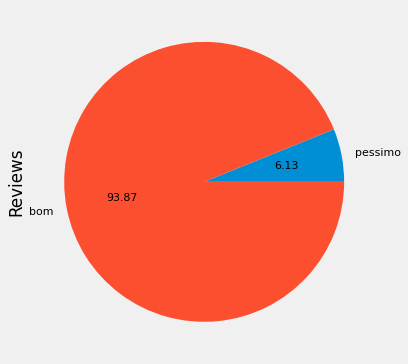

In [175]:
'''
In this cell I created a new pandas dataframe with reviews counting, and then I ploted it into a pie chart 
'''

chart = df_spark\
.filter("avaliacao <> 'outros' ")\
.groupBy('avaliacao').count()\
.toPandas()

reviews = chart.avaliacao.to_list()
qtde = chart['count'].astype(int).to_list()

pie_chart = pd.Series(qtde, index=reviews, name='Reviews')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));




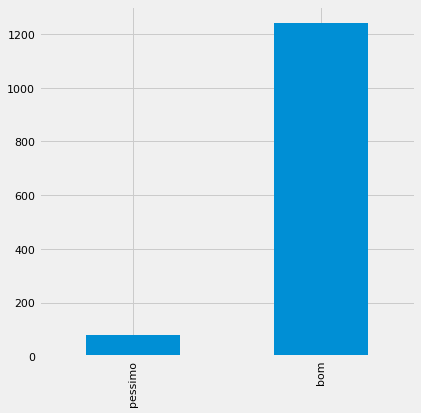

In [177]:
'''The same as the previous cell, but using bar chart'''

chart = df_spark\
.filter("avaliacao <> 'outros' ")\
.groupBy('avaliacao').count()\
.toPandas()

reviews = chart.avaliacao.to_list()
qtde = chart['count'].astype(int).to_list()

bar = pd.Series(qtde, index=reviews, name='Reviews')
bar.plot.bar(fontsize=11,  figsize=(6, 6));

In [230]:
'''Created a top 6 sum_price dataframe'''

top_6_price = df\
.groupBy("product_category_name")\
.agg(sum("price")\
.alias("sum_price"))\
.sort(desc("sum_price"))\
.limit(6)
  
# top_6_price.show()
  

+---------------------+------------------+
|product_category_name|         sum_price|
+---------------------+------------------+
|         beleza_saude|1263138.5400000177|
|   relogios_presentes|1206075.3300000136|
|      cama_mesa_banho|1050936.6100000404|
|        esporte_lazer|  993656.510000022|
| informatica_acess...| 919640.5400000147|
|     moveis_decoracao| 736282.4700000079|
+---------------------+------------------+



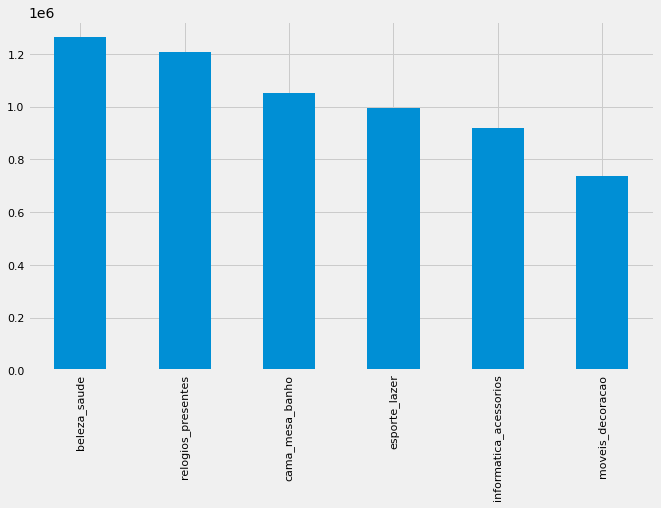

In [233]:

'''the same top 6 just created, but viewd in bars'''
top_6_price = top_6_price.toPandas()

category = top_6_price.product_category_name.to_list()
price = top_6_price.sum_price.astype(float).to_list()

bar = pd.Series(price, index=category, name='Reviews')
bar.plot.bar(fontsize=11,  figsize=(10, 6));



In [ ]:
# Qtde_Linhas_olist_orders
# Qtde_Linhas_olist_order_reviews
# Qtde_Linhas_olist_orders_items
# Qtde_Linhas_olist_products
# volume_total_linhas
# top_10_categoria